In [2]:
#load the necessary packages
library(data.table)
library(Seurat, lib='/share/home/chenjy/SDcon/Seurat5.0.1')
source('../R/main.R')
source('../R/help.R')

#load the datasets
load("../scdata/MOB/MOB.dge.sceset.RData")
load("../spdata/MOB/Rep12_MOB_count_matrix-1.RData")
load("../spdata/MOB/Rep12_MOB_manual_annotation.RData")

count_matrix=as.data.frame(t(assays(sce)$counts))
meta = as.data.frame(colData(sce))
meta['cellType'][meta['cellType']=='M/TC']='M_TC'
rownames(count_matrix)=paste0('cell', 1:nrow(count_matrix))
rownames(meta)=paste0('cell', 1:nrow(meta))

#construct the SeuratObject for scdata
seu <- CreateSeuratObject(counts = t(count_matrix))
active_ident=as.matrix(meta[,'cellType'])
colnames(active_ident)=NULL
rownames(active_ident)= rownames(meta)
Idents(seu)=active_ident[,1]
cell_names=rownames(as.matrix(Idents(seu)))

载入需要的程辑包：SingleCellExperiment

载入需要的程辑包：SummarizedExperiment

载入需要的程辑包：MatrixGenerics

载入需要的程辑包：matrixStats


载入程辑包：‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats, rowProds, rowQuantiles, rowRanges, rowRanks,
    rowSdDiffs, rowSd

In [3]:
#Quality control of the spatial transcriptomic data and corresponding spatial spots
celltype=c('GC','PGC','M_TC','OSNs','EPL-IN')
Num_celltype=length(celltype)

geneexpr=as.matrix(t(MOB_raw))
rownames(geneexpr) = paste0("spot",1:nrow(geneexpr))
threshold <- 20
filtered_rows <- geneexpr[rowSums(geneexpr) > threshold, ]
filtered_matrix <- filtered_rows[, colSums(geneexpr) > threshold]

pos <- cbind.data.frame(x=as.numeric(sapply(strsplit(colnames(MOB_raw),split="x"),"[",1)),y=as.numeric(sapply(strsplit(colnames(MOB_raw),split="x"),"[",2)))
colnames(pos) = c("x", "y")
rownames(pos) = paste0("spot",1:nrow(pos))
aligned_pos=align_pos(pos,filtered_matrix)

In [4]:
#Run DEG analysis on scdata to identify top 50 marker genes for each cell types

selected_sc_count = as.matrix(seu@ assays$RNA$counts)
selected_sc_meta =as.data.frame(Idents(seu))

colnames(selected_sc_meta) = "cellType"
selected_sc_meta$sampleInfo = rownames(selected_sc_meta)

selection_seu <- CreateSeuratObject(counts = selected_sc_count,min.features = 200,min.cells=3)

active_ident=as.matrix(selected_sc_meta[,'cellType'])
colnames(active_ident)=NULL
rownames(active_ident)= rownames(selected_sc_meta)

Idents(selection_seu)=active_ident[,1]
cell_names=rownames(as.matrix(Idents(selection_seu)))

selection_seu = SCTransform(selection_seu)
all.markers <- FindAllMarkers(selection_seu)

library(dplyr)
all.markers %>%
  group_by(cluster) %>%
  top_n(n = 50, wt = avg_log2FC) -> top50

top_DEGs =dplyr::rename(top50,'label'='cluster')
top_DEGs=top_DEGs %>% arrange(label, desc(avg_log2FC))  

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.8 GiB”
Warning message:
“Data is of class matrix. Coercing to dgCMatrix.”
Running SCTransform on assay: RNA

Running SCTransform on layer: counts

vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

Variance stabilizing transformation of count matrix of size 15939 by 12801

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 5000 cells

Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = FALSE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = FALSE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = FALSE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = FALSE.”
Warning message:
“useNames = NA is deprecated. Instead, s

In [8]:
rm(seu)

Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = FALSE.”


[1] "filtered celltype"
[1] GC     PGC    M_TC   OSNs   EPL-IN
Levels: GC PGC M_TC OSNs EPL-IN
[1] "Sema3c" "Icam5"  "Gria3"  "Penk"  
[1] "Vip"      "Hpcal1"   "AI593442" "Syndig1l"
[1] "Wif1"   "Cbln4"  "Sv2b"   "Shisa3"
[1] "Omp"
[1] "Chl1"
[1] "Num of Marker"
[1] 14


Removing 85 genes present in 100% or more of pixels...

10630 genes remaining...

Removing 0 genes present in 5% or less of pixels...

10630 genes remaining...

Restricting to overdispersed genes with alpha = 0.05...

Calculating variance fit ...

Using gam with k=5...

200 overdispersed genes ... 

 Using top 1000 overdispersed genes.


 number of top overdispersed genes available: 200


Time to fit LDA models was 0.12 mins

Computing perplexity for each fitted model...

Time to compute perplexities was 0 mins

Getting predicted cell-types at low proportions...

Time to compute cell-types at low proportions was 0 mins

Plotting...

Warning message in ggplot2::geom_point(ggplot2::aes(y = rareCtsAdj, x = K), col = "blue", :
“Ignoring unknown parameters: `linewidth`”
Warning message in ggplot2::geom_point(ggplot2::aes(y = perplexAdj, x = K), col = "red", :
“Ignoring unknown parameters: `linewidth`”
`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the gr

         1          2          3          4          5 
0.43994262 0.01501608 0.03415694 0.01773478 0.49314957 
         1          2          3          4          5 
0.07676162 0.43314122 0.17088824 0.17822587 0.14098305 
         1          2          3          4          5 
0.01201962 0.03029573 0.87483820 0.05489215 0.02795429 
         1          2          3          4          5 
0.15459970 0.09743856 0.05916407 0.54409920 0.14469847 
         1          2          3          4          5 
0.18420596 0.05688450 0.01173681 0.28664420 0.46052854 
         1          2          3          4          5 
0.06987901 0.16730445 0.63672918 0.06854275 0.05754461 
         1          2          3          4          5 
0.69666885 0.03003406 0.04642708 0.02088319 0.20598682 
iter = 1, loglik= -5583404.447079, dloglik= inf 
iter = 1, loglik= -5583404.447079, dloglik= inf 
iter = 1, loglik= -1015815.529706, dloglik= inf 
iter = 1, loglik= -876091.624654, dloglik= inf 
iter = 1, loglik= -87

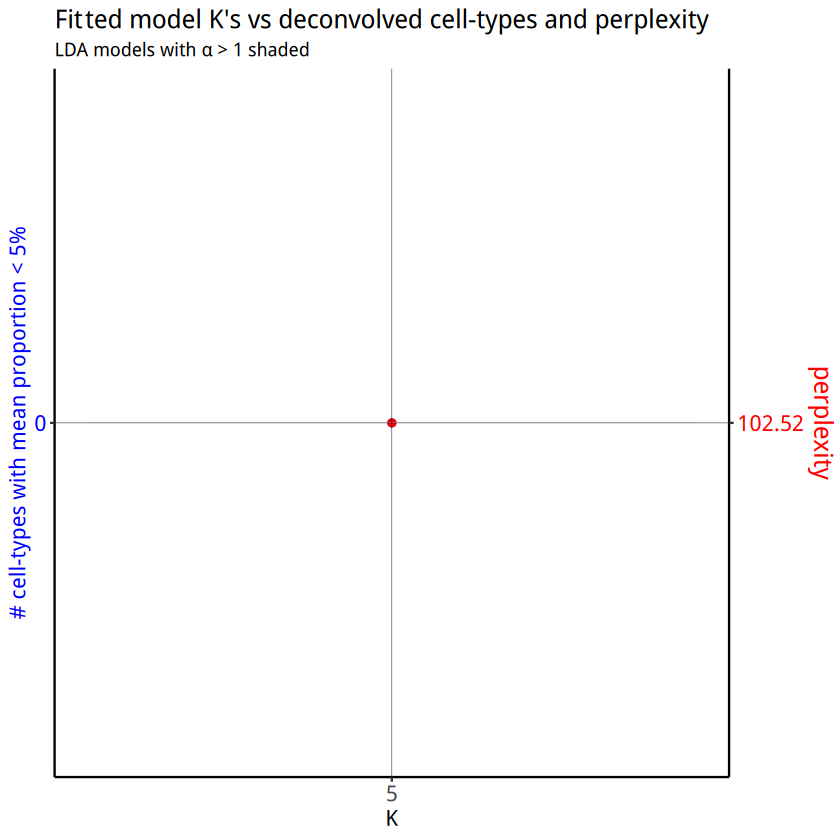

In [14]:
#cell-type deconvolution using QR-SIDE
source('../R/main.R')

sp_expr=filtered_matrix # Spot by gene SRT matrix

sp_pos=aligned_pos #Spot by 2, 2D spatial coordination

top_DEGs=top_DEGs #DEGs dataframe from Seurat sorted by 'avg_log2FC'

Num_topic=7 #Num of topic domains

Num_HVG=1000 #num of highly variable genes used in QR_SIDE

dim_embed=20 #dimension of embeddings in hierachical factor models

top_marker_num=4 #Num of markers of each cell type from "top_DEGs" used in QR_SIDE 

fixed_marker_list=FALSE #whether QR-SIDE uses the all genes in "top_DEGs" as markers. If FALSE, "top_marker_num" must be provided

out=QR_SIDE(sp_expr, sp_pos, top_DEGs, Num_topic, Num_HVG, dim_embed, top_marker_num, fixed_marker_list)

In [15]:
#visualzie the cell-type proportion
library(CARD)

idx_list=c()
proportion = matrix(0,nrow(out$pi),ncol(out$beta))
  for (i in 1:nrow(out$pi)){
    idx = which.max(out$pi[i,])
    idx_list=append(idx_list,idx)
    proportion[i,] = out$beta[idx,]
  }

colnames(proportion)=celltype[out$order]

color=c('#E0E0EE','#DF4D4F','#F08B21','#D0B14C','#4374A4')

rownames(proportion) = rownames(aligned_pos)
idx_list=as.matrix(idx_list)
rownames(idx_list)=rownames(aligned_pos)

CARD.visualize.pie(proportion = proportion,spatial_location = aligned_pos, color=color, radius=0.45)

Registered S3 methods overwritten by 'registry':
  method               from 
  print.registry_field proxy
  print.registry_entry proxy

Warning message:
“replacing previous import ‘RcppML::nmf’ by ‘NMF::nmf’ when loading ‘CARD’”
